# Zillow Zestimate Competition 2017
## Linear regression algorithm attempt

In [86]:
import numpy as np #arrays and matrices
import pandas as pd #data analysis
import matplotlib.pyplot as plt #plotting and visualizations
import pprint as pp #tidying up dictionaries (in our case)
%matplotlib inline 
#make the matplotlib graphs show in the notebook
import gc #garbage collection, for memory management

### Bring In The Data

In [87]:
train_df_raw= pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"]) #need the file to be in the same directory level as this notebook file
prop = pd.read_csv("properties_2016.csv") #, usecols=good_import_cols) #the properties of each house, where each house is known as parcelid in the data

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Remove and Impute Nulls
##### Impute = "assign (a value) to something by inference from the value of the products or processes to which it contributes."

In [88]:

train_df_merged = train_df_raw.merge(prop, on='parcelid', how = 'left')

missing_df = train_df_merged.isnull().sum(axis=0).reset_index() # Finds the number of missing values per column in property file and reset index for the next operation

missing_df.columns = ['column_name', 'missing_count'] # Assign names for the only 2 columns
missing_df = missing_df.loc[missing_df['missing_count']>0] # Remove any features that have no empty rows aka any columns completely filled
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df_merged.shape[0] # Create new column for ratio of empties
missing_df_over75 = missing_df.loc[missing_df['missing_ratio']>0.75] # Remove any with less than 75% vals missing
print(missing_df.sort_values('missing_count', ascending=False)) # Printed to compare the cols that were dropped by the last action
print(missing_df_over75.sort_values('missing_count', ascending=False))


                     column_name  missing_count  missing_ratio
8            buildingclasstypeid          90259       0.999823
15          finishedsquarefeet13          90242       0.999634
5                   basementsqft          90232       0.999524
43                   storytypeid          90232       0.999524
48            yardbuildingsqft26          90180       0.998948
51                 fireplaceflag          90053       0.997541
4       architecturalstyletypeid          90014       0.997109
45        typeconstructiontypeid          89976       0.996688
18           finishedsquarefeet6          89854       0.995336
11                    decktypeid          89617       0.992711
30                   poolsizesum          89306       0.989266
31                  pooltypeid10          89114       0.987139
32                   pooltypeid2          89071       0.986663
57            taxdelinquencyflag          88492       0.980249
58            taxdelinquencyyear          88492       0

We see here that some number of cols were dropped by our limit of 75% missing vals. Let's see exactly how many.

In [89]:
print(missing_df.shape, missing_df_over75.shape) # The shape of the two tuples

(47, 3) (25, 3)


In [90]:
print(missing_df.shape[0] - missing_df_over75.shape[0]) # The num of vars with less than 75% of missing vals

22


In [91]:
# Make parcel id the index 
train_df_merged.index = train_df_merged.parcelid

In [92]:
train_df_dropna = train_df_merged.drop(missing_df_over75.column_name.tolist(), axis = 1) # Remove the cols with > 75% missing vals
train_df_dropna = train_df_dropna.drop(['parcelid'],axis = 1)
train_df_dropna # The remaing NaN vals are where data is missing

,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,...,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
14366692,-0.1684,2016-01-01,NaN,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,...,96962.0,0.0,NaN,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
12098116,-0.0040,2016-01-01,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,...,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
12643413,0.0218,2016-01-02,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,...,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
14432541,-0.0050,2016-01-02,NaN,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,...,96961.0,8.0,NaN,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13
11509835,-0.2705,2016-01-02,1.0,4.0,4.0,1.0,4.0,3067.0,3067.0,6037.0,...,96109.0,0.0,1.0,1982.0,880650.0,2447951.0,2015.0,1567301.0,27126.57,6.037621e+13
12286022,0.0440,2016-01-02,NaN,1.0,2.0,7.0,1.0,1297.0,1297.0,6037.0,...,96091.0,0.0,1.0,1939.0,64549.0,111521.0,2015.0,46972.0,2304.97,6.037542e+13
17177301,0.1638,2016-01-02,NaN,2.5,3.0,NaN,2.5,1763.0,1763.0,6111.0,...,97101.0,6.0,NaN,1994.0,107000.0,306000.0,2015.0,199000.0,3745.50,6.111003e+13
14739064,-0.0030,2016-01-02,NaN,1.0,2.0,NaN,1.0,796.0,796.0,6059.0,...,96987.0,0.0,NaN,1984.0,66834.0,210064.0,2015.0,143230.0,2172.88,6.059042e+13


In [93]:
# Impute the mean where columns are still missing vals 

mean_values = train_df_dropna.mean(axis=0) #returns Series
train_df_filledna = train_df_dropna.fillna(mean_values, inplace=True) # The actual imputing
print(train_df_filledna)

          logerror transactiondate  airconditioningtypeid  bathroomcnt  \
parcelid                                                                 
11016594    0.0276      2016-01-01               1.000000          2.0   
14366692   -0.1684      2016-01-01               1.816372          3.5   
12098116   -0.0040      2016-01-01               1.000000          3.0   
12643413    0.0218      2016-01-02               1.000000          2.0   
14432541   -0.0050      2016-01-02               1.816372          2.5   
11509835   -0.2705      2016-01-02               1.000000          4.0   
12286022    0.0440      2016-01-02               1.816372          1.0   
17177301    0.1638      2016-01-02               1.816372          2.5   
14739064   -0.0030      2016-01-02               1.816372          1.0   
14677559    0.0843      2016-01-03               1.816372          2.0   
10854446    0.3825      2016-01-03               1.816372          2.0   
11672170   -0.0161      2016-01-03    

Notice how the vals previously NaN are now filled in. The values used are the mean of the other values for each feature aka each column.

In [94]:
# Add the month to the data frame 

train_df_filledna['transaction_month'] = np.float64(train_df_filledna['transactiondate'].dt.month.values) # Extract and convert the month portion of date to a float value
group_train_months = train_df_filledna.groupby(by=['transaction_month']).logerror.count() # Calculates the number of given results based on the month vals just extracted
group_train_months

transaction_month
1.0      6556
2.0      6333
3.0      8652
4.0      9311
5.0      9961
6.0     10922
7.0      9947
8.0     10476
9.0      9575
10.0     4977
11.0     1826
12.0     1739
Name: logerror, dtype: int64

Let's plot this data to get a better idea of it.

In [95]:
npFloat_group_months = np.float64(group_train_months.index)
npFloat_group_months

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

In [96]:
 list_group_train = group_train_months.values.tolist()

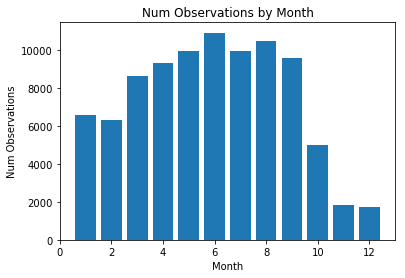

In [97]:
fig, ax = plt.subplots()
bar_width = 0.35

cols = npFloat_group_months
counts = list_group_train

barplot = plt.bar(cols, counts)
plt.xlabel('Month')
plt.ylabel('Num Observations')
plt.title('Num Observations by Month')


Summer months appear to be high times of selling. The last few months are skewed by fewer observations.

The next steps are a method to find variables that may be extreme or categorical.

In [112]:
missing_df_over75

,column_name,missing_count,missing_ratio
4,architecturalstyletypeid,90014,0.997109
5,basementsqft,90232,0.999524
8,buildingclasstypeid,90259,0.999823
11,decktypeid,89617,0.992711
12,finishedfloor1squarefeet,83419,0.924054
15,finishedsquarefeet13,90242,0.999634
16,finishedsquarefeet15,86711,0.960521
17,finishedsquarefeet50,83419,0.924054
18,finishedsquarefeet6,89854,0.995336
20,fireplacecnt,80668,0.893581


In [98]:
numb_unique_per_col = train_df_filledna.T # Transpose the training dataset
numb_unique_per_col = numb_unique_per_col.apply(lambda x: x.nunique(), axis = 1) # Apply function to each column to get num of unique vals 
numb_unique_per_col.sort_values(0, ascending = True)

assessmentyear                      1
fips                                3
regionidcounty                      3
airconditioningtypeid               7
buildingqualitytypeid               9
unitcnt                            11
transaction_month                  12
heatingorsystemtypeid              13
propertylandusetypeid              14
fullbathcnt                        15
garagecarcnt                       16
bedroomcnt                         17
roomcnt                            17
bathroomcnt                        23
calculatedbathnbr                  23
propertycountylandusecode          77
yearbuilt                         131
regionidcity                      178
transactiondate                   352
regionidzip                       389
regionidneighborhood              495
garagetotalsqft                   871
logerror                         1894
propertyzoningdesc               1996
finishedsquarefeet12             4983
calculatedfinishedsquarefeet     5103
lotsizesquar

Three columns stand out here: assessmentyear, fips, and regionidcounty.

In [99]:
train_df_filledna = train_df_filledna.drop(['assessmentyear'],axis=1)

In [100]:
numb_unique_per_col[numb_unique_per_col == 1]

assessmentyear    1
dtype: int64

In [101]:
train_df_filledna.dtypes[train_df_filledna.dtypes != "float64"].index


Index(['transactiondate', 'propertycountylandusecode', 'propertyzoningdesc'], dtype='object')

In [102]:
train_df_filledna['propertycountylandusecode']
#found strings

parcelid
11016594    0100
14366692       1
12098116    0100
12643413    010C
14432541     122
11509835    0100
12286022    0100
17177301    1129
14739064      34
14677559      34
10854446    0100
11672170    0100
10949761    0100
14665244       1
14148540     122
14057104     122
17296797    1128
12524288    010E
14091502     122
10815909    0100
12453853    0100
14253461     122
14001034     122
11458863    0104
13957980     122
12752047    0100
11188425    0100
14646051      34
10805063    010E
12524725    010C
            ... 
10757551    0100
12558267    01HC
11710734    0100
14347592     122
11341061    0100
14027878     122
12756771    0100
12758333    010C
11295458    010C
12757889    0100
11308315    0100
14353215     122
10753416    010C
11756902    010C
11994047    010C
11440746    010C
11703478    0100
10965821    0100
12067066    010C
11683263    010C
12062080    010C
12265636    0200
17109680    1111
12268527    0100
12920746    0100
10774160    010C
12046695    0100
12995

In [103]:
train_df_filledna['propertycountylandusecode'].nunique()

77

In [104]:
train_df_filledna['propertyzoningdesc']

parcelid
11016594          LARS
14366692           NaN
12098116          PSR6
12643413          LAR3
14432541           NaN
11509835        HBR3YY
12286022         CORH*
17177301           NaN
14739064           NaN
14677559           NaN
10854446         LARE9
11672170          LAR1
10949761         BUR1*
14665244           NaN
14148540           NaN
14057104           NaN
17296797           NaN
12524288         LBR4R
14091502           NaN
10815909          LAR1
12453853         LBR1N
14253461           NaN
14001034           NaN
11458863          LAR1
13957980           NaN
12752047         LMR1*
11188425    PDRPD6.6U*
14646051           NaN
10805063          LAR3
12524725         LBR4N
               ...    
10757551          LAR1
12558267         LBPD6
11710734          LAR1
14347592           NaN
11341061     LCR17500*
14027878           NaN
12756771        NOR1YY
12758333     NOR1(R3)*
11295458    LRRPD75002
12757889        NOR1YY
11308315      LRR7000*
14353215           NaN
10

In [105]:
train_df_filledna['propertyzoningdesc'].nunique()

1996

In [106]:
# Drop non numeric (float64) columns 
#cols_to_drop = cols_to_drop.append(train_df.dtypes[train_df.dtypes != "float64"].index)
#train_df2 = train_df.drop(cols_to_drop, axis = 1)
train_df2 = train_df_filledna

In [107]:
missing_df2 = train_df2.isnull().sum(axis=0).reset_index()
missing_df2.columns = ['count', 'val']
missing_df2[missing_df2['val'] > 0]


,count,val
17,propertycountylandusecode,1
19,propertyzoningdesc,31962


In [108]:
train_df2.head()

,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,transaction_month
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,1.000000,2.0,3.0,4.000000,2.0,1684.0,1684.0,6037.0,...,96370.0,0.0,1.000000,1959.0,122754.0,360170.0,237416.0,6735.88,6.037107e+13,1.0
14366692,-0.1684,2016-01-01,1.816372,3.5,4.0,5.565407,3.5,2263.0,2263.0,6059.0,...,96962.0,0.0,1.110414,2014.0,346458.0,585529.0,239071.0,10153.02,6.049151e+13,1.0
12098116,-0.0040,2016-01-01,1.000000,3.0,2.0,4.000000,3.0,2217.0,2217.0,6037.0,...,96293.0,0.0,1.000000,1940.0,61994.0,119906.0,57912.0,11484.48,6.037464e+13,1.0
12643413,0.0218,2016-01-02,1.000000,2.0,2.0,4.000000,2.0,839.0,839.0,6037.0,...,96222.0,0.0,1.000000,1987.0,171518.0,244880.0,73362.0,3048.74,6.037296e+13,1.0
14432541,-0.0050,2016-01-02,1.816372,2.5,4.0,5.565407,2.5,2283.0,2283.0,6059.0,...,96961.0,8.0,1.110414,1981.0,169574.0,434551.0,264977.0,5488.96,6.059042e+13,1.0


### One hot encoding 

In [109]:
from sklearn.preprocessing import OneHotEncoder

In [110]:
one_hot_colnames_before = ["typeconstructiontypeid", "architecturalstyletypeid", "airconditioningtypeid", 
                    "heatingorsystemtypeid", "propertylandusetypeid", "transaction_month"]

In [111]:
#one_hot_df = OneHotEncoder().fit_transform(train_df2[one_hot_colnames].values)
one_hot_df = pd.DataFrame()
for col_name in one_hot_colnames_before:
    temp_one_hot_var1 = OneHotEncoder().fit_transform(train_df2[col_name].values.reshape(-1,1))
    temp_one_hot_var = temp_one_hot_var1.toarray()
    temp_one_hot_var_df1 = pd.DataFrame(data=temp_one_hot_var)
    temp_one_hot_var_df = temp_one_hot_var_df1.add_prefix(col_name + "_") # Add the name to each column 
    one_hot_df = pd.concat([one_hot_df, temp_one_hot_var_df] , axis = 1)
print("Data Frame Dimensions: " ,one_hot_df.shape)
one_hot_df.index = train_df2.index

KeyError: 'typeconstructiontypeid'

In [ ]:
one_hot_colnames_after = one_hot_df.columns

Find a better way to implement the code below 

In [ ]:
train_df3 = train_df2.drop(one_hot_colnames_before, axis = 1)
train_df3 = pd.concat([train_df3, one_hot_df], axis = 1)

In [ ]:
print("Dataset dimensions ",train_df3.shape)
train_df3.head()

In [ ]:
del train_df2
gc.collect()

### Scale Data

In [ ]:
train_df3 = train_df_filledna

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
# missing_df3 = missing_df2[missing_df2['val'] > 0]
missing_df3['count'].values

In [ ]:
train_df3.drop(missing_df3['count'].values,axis = 1)

In [ ]:
df_temp = train_df3.drop(missing_df3['count'].values,axis = 1)
df_temp2 = df_temp.drop(['transactiondate'], axis = 1)
train_df_scale = StandardScaler().fit_transform(df_temp2)
#train_df_scale = MinMaxScaler().fit_transform(train_df3.drop(cols_not_to_scale),axis = 1)
train_df_scale = pd.DataFrame(train_df_scale)
train_df_scale.columns =df_temp2.columns
train_df_scale.index = df_temp2.index

In [ ]:
train_df_scale.head()

In [ ]:
train_y = train_df_scale['logerror']

In [ ]:
train_y.size

## Flooring and Capping 

In [ ]:
ceil_y = train_y.quantile(q= 0.99)
floor_y = train_y.quantile(q=0.01)

In [ ]:
train_df3['logerror'].describe()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df3['logerror'].size), np.sort(train_df3['logerror']))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.axhline(y = ceil_y, linewidth = 2, color = 'r')
plt.axhline(y = floor_y, linewidth = 2, color = 'r')
plt.legend(['values', 'extreme values'])
plt.show()

In [ ]:
train_y[train_y > ceil_y] = ceil_y
train_y[train_y < floor_y] = floor_y

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(train_y, bins = 30)
plt.xlabel('logerror', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_y.size), np.sort(train_y))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [ ]:
print("Min value: ",min(train_y))
print("Max value: ", max(train_y)) 

In [ ]:
train_df_scale.shape

In [ ]:
train_df_scale.head()

### Combine and Prepare for Modeling

In [ ]:
train_df_modeling = train_df_scale.drop(["logerror"], axis =1 )
train_df_modeling.head()

In [ ]:
train_df_modeling.describe()

In [ ]:
train_df_modeling.shape

In [ ]:
train_df_modeling.values

## Linear Regression

### Start by splitting into test train set 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = train_df_modeling
y = train_y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
results.params[abs(results.params) > 0.02]

In [ ]:
results.pvalues[results.pvalues < 0.05]

In [ ]:
print("Number of pvalue variables: ", len(results.pvalues[results.pvalues < 0.05]))
print("Number of pvalue variables: ", len(results.params[abs(results.params) > 0.02]))

## Examine Validation Set 

In [ ]:
test_pred = results.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, roc_auc_score, roc_curve

In [ ]:
r2_dev = r2_score(y_train, results.fittedvalues)
r2_dev

In [ ]:
r2_itv = r2_score(y_test, test_pred)
r2_itv

In [ ]:
(r2_dev/r2_itv - 1)*100

In [ ]:
mean_absolute_error(y_test, test_pred)

In [ ]:
plt.scatter(y_test, test_pred)
plt.xlabel("Actual")
plt.ylabel("Model Predictions")
plt.title("Actuals vs Model Predictions")


In [ ]:
results = pd.DataFrame(data = {"y_test": y_test, "test_pred": test_pred})

In [ ]:
fig, ax = plt.subplots()
ax.scatter(results.y_test[abs(results.test_pred) < 0.25], results.test_pred[abs(results.test_pred) < 0.25])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.xlabel("Actual")
plt.ylabel("Model Predictions")
plt.title("Actual vs Model Predictions")

### VIF Analysis  
We may want to hold this until later when we have a smaller model..

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
print(len(vif))
print(len(X.columns))

In [ ]:
vif_series = pd.Series(data = vif, index = X.columns)

In [ ]:
vif_series.sort_values()

In [ ]:
vif_series.describe()

In [ ]:
vif_series[vif_series < 5]

In [ ]:
inf_vif_list = vif_series[vif_series == np.inf].index

In [ ]:
vif_series1 = vif_series.drop(inf_vif_list.tolist())

In [ ]:
len(vif_series1)

In [ ]:
vif_series1.head()

In [ ]:
X_vif1 = X.drop(inf_vif_list.tolist(), axis =1)

In [ ]:
X_vif1.shape

In [ ]:
numb_X_cols = X_vif1.shape[1]
X_ndarray_vif1 =X_vif1.values
vif1 = [variance_inflation_factor(X_ndarray_vif1, i) for i in range(numb_X_cols)]

In [ ]:
vif1_series = pd.Series(data = vif1, index = X_vif1.columns) 

In [ ]:
vif1_series.describe()

### Examine Predictions 

In [ ]:
train_predictions = model1.predict(train_df_modeling.values)

In [ ]:
plt.hist(train_predictions, bins = 30)

#plt.hist(train_y)


In [ ]:
plt.hist(train_y.values, bins = 30)

In [ ]:
train_predictions

In [ ]:
len(train_predictions)

In [ ]:
flat_train_preds = []
for prediction in range(0, len(train_predictions)):
    flat_train_preds = train_predictions[prediction][0]

In [ ]:
plt.plot(model2.history['mean_absolute_error'])
plt.plot(model2.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Submission Steps

In [ ]:
train_df_new = pd.read_csv("train_2016.csv")
test = pd.read_csv("sample_submission.csv")
prop = pd.read_csv("properties_2016.csv")

In [ ]:
test['parcelid'] = test['ParcelId']
df_test = test.merge(prop, on='parcelid', how = 'left') 
print("Test DF len: " ,len(df_test))
print("Input DF len: ", len(test))

In [ ]:
train_cols1 = train_cols[1:len(train_cols)]

In [ ]:
x_test2 = df_test[train_cols1]
test_mean_values = x_test2.mean(axis=0)
x_test1 = x_test2.fillna(test_mean_values, inplace=True)
x_test = StandardScaler().fit_transform(x_test1)

In [ ]:
predictions = batch_model.predict(x_test)

In [ ]:
sub = pd.read_csv("sample_submission.csv")
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = predictions

In [ ]:
sub.to_csv('nn_starter2.csv', index=False, float_format='%.4f')

In [ ]:
sub.shape